# Convolutional Neural Network Model

## 1-  Importing Required Libraries

In [1]:
# Importing Required Libraries
import csv
import ast
import folium
import numpy as np
import pandas as pd
import datetime
import math

import h5py
import matplotlib.pyplot as plt
from pylab import rcParams
import scipy
#from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *                             # Required to run CNN model
from sklearn.model_selection import train_test_split

%matplotlib inline


c:\users\reese\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2 - Loading All Arranged Data (Years 2013-2011)

In [2]:
# Importing the 2013 Data to merge with the 2012 Data
from numpy import genfromtxt

Features_13_12_11 = genfromtxt('All Features (13-12-11).csv', delimiter=',')
Labels_13_12_11 = genfromtxt('All Labels (13-12-11).csv', delimiter=',')

In [3]:
# Removing Days, Months and Hours from Data
Features_13_12_11 = Features_13_12_11[:,18:]
Labels_13_12_11 = Labels_13_12_11[:,3:]

In [4]:
# Smoothing The Data
for i in range(96):
    Features_13_12_11[:,i] = pd.rolling_mean(Features_13_12_11[:,i],window=2,min_periods=0)
    
Labels_13_12_11 = pd.rolling_mean(Labels_13_12_11,window=4,min_periods=0)

c:\users\reese\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\reese\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


In [5]:
# Reshaping Data to 3d Form
Features_13_12_11 = np.reshape(Features_13_12_11, (26262,16,6))
Labels_13_12_11 = np.reshape(Labels_13_12_11, (26262,16))

In [6]:
# Creating Train and Test Splits

Train_Features,Test_Features,Train_Labels,Test_Labels = train_test_split(Features_13_12_11, Labels_13_12_11, test_size=0.10)



In [7]:
# Checking Shapes of Train-Test Sets
print(Train_Features.shape)
print(Train_Labels.shape)
print(Test_Features.shape)
print(Test_Labels.shape)

(23635, 16, 6)
(23635, 16)
(2627, 16, 6)
(2627, 16)


## 3- CNN Model Creation

In [8]:
# Creating Placeholders Function

def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape = (None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape = (None,n_y))
    
    return X, Y

In [9]:
# Creating Placeholders for Sample Data
X, Y = create_placeholders(16, 6, 1, 16)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 16, 6, 1), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 16), dtype=float32)


In [10]:
# Initializing Parameters Function

def initialize_parameters():

            
    W1 = tf.get_variable("W1", [3,3,1,16], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [3,3,16,32], initializer = tf.contrib.layers.xavier_initializer())
    W3 = tf.get_variable("W3", [3,3,32,64], initializer = tf.contrib.layers.xavier_initializer())
    W4 = tf.get_variable("W4", [3,3,64,32], initializer = tf.contrib.layers.xavier_initializer())
    

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4}
    
    return parameters

In [11]:
# Initializing Parameters for Sample Data
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[0,1,0]))
    print("W2 = " + str(parameters["W2"].eval()[0,1,0]))
    print("W3 = " + str(parameters["W3"].eval()[0,1,0]))

W1 = [ 0.01788114 -0.0495061   0.04847084  0.1730976   0.03559376 -0.00648545
  0.17577781 -0.01748006  0.18650798  0.1681162  -0.04764318  0.04461554
  0.12587313 -0.15268157  0.05394559  0.00563531]
W2 = [ 0.03100323 -0.02303635 -0.07884979 -0.0703008  -0.07091525 -0.08550286
 -0.04693218 -0.07616365 -0.06691978  0.0092072   0.01993916 -0.11553651
  0.09607383  0.06925621 -0.05053472  0.06738449 -0.1081709   0.03921606
  0.01617806  0.04397178  0.10387816  0.07711308  0.10294542 -0.02738062
 -0.0015396   0.05035458 -0.06581854  0.02421615 -0.04380249 -0.08378563
 -0.08835373 -0.05503473]
W3 = [-0.01904986  0.0632178  -0.04621403 -0.01197311  0.03416878 -0.04682384
  0.01223627  0.05854984  0.07615969  0.00661435  0.07755367 -0.04584116
 -0.07445272 -0.06684469 -0.06844807 -0.0144411   0.05966587  0.00434253
  0.03973158  0.03495058  0.0472265   0.0808694   0.07947103  0.00229862
 -0.07966858 -0.06294539 -0.04784616  0.00498893 -0.08164768  0.01099666
 -0.02475731  0.04851136 -0.00419

In [12]:
# Forward Propagation Function

def forward_propagation(X, parameters):

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(A1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 2x2, stride 2 padding 'SAME'
    P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # CONV2D: filters W3, stride 1, padding 'SAME'
    ZX = tf.nn.conv2d(P1,W3,strides=[1,1,1,1],padding='SAME')
    # RELU
    A3 = tf.nn.relu(ZX)
    
    # CONV2D: filters W4, stride 1, padding 'SAME'
    ZY = tf.nn.conv2d(A3,W4,strides=[1,1,1,1],padding='SAME')
    # RELU
    A4 = tf.nn.relu(ZY)
    
    # MAXPOOL: window 2x2, stride 2 padding 'SAME'
    P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # FULLY-CONNECTED Layer (256 Neurons)
    ZZ = tf.contrib.layers.fully_connected(P2, num_outputs=256, activation_fn=None)
    
    # RELU
    A5 = tf.nn.relu(ZZ)

    # FULLY-CONNECTED Layer (128 Neurons)
    ZXX = tf.contrib.layers.fully_connected(A5 , num_outputs=128, activation_fn=None)

    # RELU
    A6 = tf.nn.relu(ZXX)
    
    # Dropout Layer (To Fix Overfitting)
    D6 = tf.nn.dropout(A6,0.9)

    # FULLY-CONNECTED Layer (16 Neurons to Match Label Output)
    Z3 = tf.contrib.layers.fully_connected(D6, num_outputs = 16, activation_fn=None)
    

   
    return Z3

In [13]:
# Forward Propagation on Sample Data
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(16, 6, 1, 16)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,16,6,1), Y: np.random.randn(2,16)})
    print("Z3 = " + str(a))

Z3 = [[-0.01936689  0.00634775  0.00694487 -0.06359305  0.01514322 -0.00138513
   0.02805991 -0.0372559   0.00392833 -0.06673275  0.06792603  0.11351185
  -0.06017748 -0.03653773  0.00261655 -0.01351479]
 [ 0.01650564 -0.0144877  -0.04093476 -0.08652934 -0.00765078  0.01684847
   0.04322959 -0.0503677   0.04953267 -0.05197486  0.07993738  0.05888886
  -0.02883139  0.00325755  0.01977541 -0.02647488]]


In [14]:
# Compute Cost Function

def compute_cost(Z3, Y):

    cost = tf.losses.mean_squared_error(
    Y,
    Z3,
    weights=1.0,
    scope=None,
    loss_collection=tf.GraphKeys.LOSSES,
)

    return cost

In [15]:
# Cost Function Sample Calculation
tf.reset_default_graph()

with tf.Session() as sess:
    #np.random.seed(1)
    X, Y = create_placeholders(16, 6, 1, 16)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()

    sess.run(init)  

    a = sess.run(cost, {X: np.random.randn(2,16,6,1), Y: np.random.randn(2,16)})
    print("cost = " + str(a))

cost = 1.3233454


In [16]:
# Reshaping Test-Train Sets to Input into CNN Model

Train_Features = (np.reshape(Train_Features, (23635,16,6,1)))
Test_Features = (np.reshape(Test_Features, (2627,16,6,1)))
Train_Labels = (np.reshape(Train_Labels, (23635,16)))
Test_Labels = (np.reshape(Test_Labels, (2627,16)))

print(np.shape((Train_Features)))
print(np.shape((Test_Features)))
print(np.shape((Train_Labels)))
print(np.shape((Test_Labels)))

(23635, 16, 6, 1)
(2627, 16, 6, 1)
(23635, 16)
(2627, 16)


In [17]:
# Model Function

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 30, minibatch_size = 128, print_cost = True):
   
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0,n_C0) = Train_Features.shape   
    n_y = Train_Labels.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        

        # Calculating the Accuracy
        Accuracy = 100*(1-tf.reduce_mean(tf.abs((Z3-Y)/Y)))

        print("Train Accuracy = ", (Accuracy).eval({X: X_train, Y: Y_train}))
        print("Test Accuracy = ", (Accuracy).eval({X: X_test, Y: Y_test}))
        
        
        return  Accuracy, parameters

## 4- Model Execution

Cost after epoch 0: 561.319823
Cost after epoch 5: 82.973758
Cost after epoch 10: 70.048105
Cost after epoch 15: 64.192545
Cost after epoch 20: 61.411530
Cost after epoch 25: 58.363419


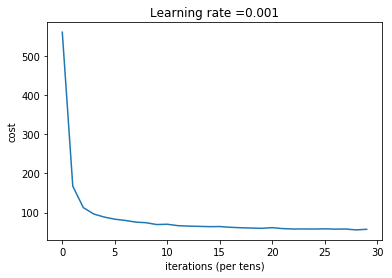

Train Accuracy =  89.62592
Test Accuracy =  89.50814


In [18]:
 Accuracy, parameters = model(Train_Features, Train_Labels, Test_Features, Test_Labels)